# Data Science Capstone project on NYC Restaurants

There is a wealth of publicly available data on NYC available on data.cityofnewyork.us - I am enriching the Foursquare provided information with this dataset on New York City Traffic flow.

There are two phases to the deliverable. Initially I want to be able to:
- (1) Visualise spatial and traffic and Foursquare data by plotting (a) Venues, (b) Traffic speeds, and (c) the map of New York city to have an overvie of the business that are easily accessible by car.
- (2) Apply filters to plot traffic data over different days and time periods.

In the second phase I intend to perform an analysis on the traffic data to better understand
- (3) what kind of businesses are located near places that have good or fast traffic throughput and 
- (4) to identify what the kinds of businesses are that have poor traffic throughput nearby.

## Data Required
- Foursquare: Foursquare API can be used to gather information about venues near a certain location. It also contains latitudes and longitudes.
- Folium is used to plot maps
- Traffic data contains speed, latitude, longitude and a number of other variables that can be used to determine the traffic throughput in that road/area.

### Data links
- Foursquare API: https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}
- Traffic Data (1): The traffic data from October 2016 https://www.kaggle.com/crailtap/nyc-real-time-traffic-speed-data-feed#october2016.csv
- Traffic Data (2): The node information for the traffic data referred to in the October 2016 dataset: https://www.kaggle.com/crailtap/nyc-real-time-traffic-speed-data-feed#linkinfo.csv

The traffic file (1) contains the following columns:
- Id
- Speed
- TravelTime
- Status
- DataAsOf
- linkId

Traffic Data file (2) contains these columns:
- linkId
- linkPoints
- EncodedPolyLine
- EncodedPolyLineLvls
- Transcom_id
- Borough
- linkName
- Owner

The Foursquare API calls will return at least the following information which I will use:
- Venue Latitude
- Venue Longitude
- Venue Category
- Venue Name

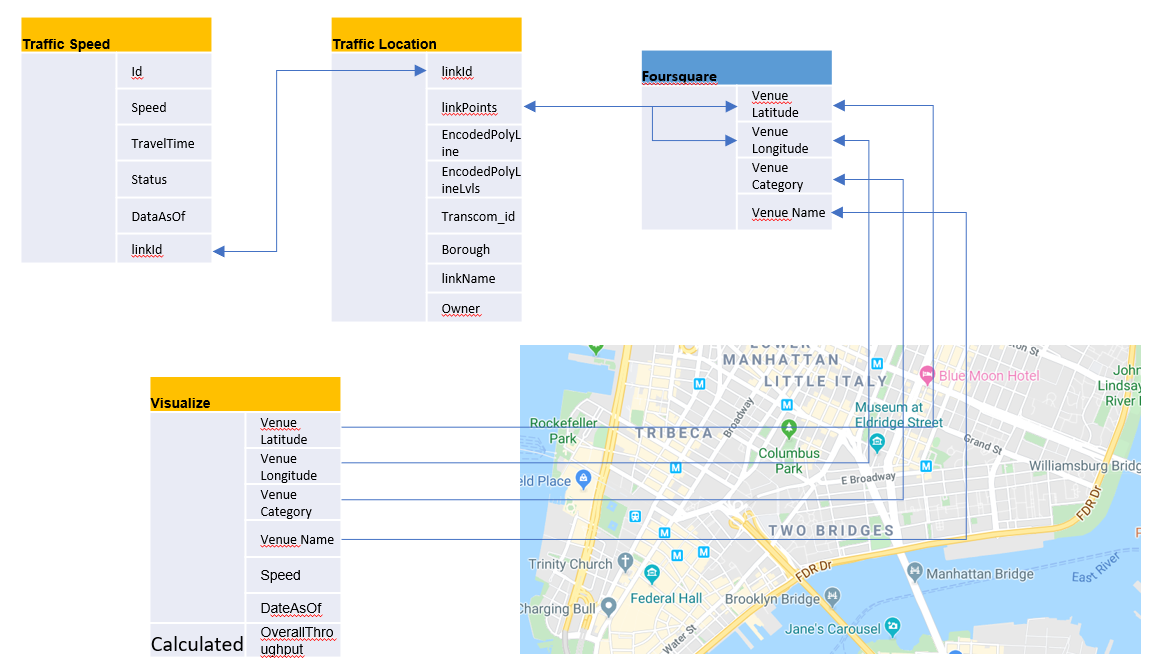


## Aproach

### 1 Visualise spatial and traffic and Foursquare data by plotting (a) Venues, (b) Traffic speeds, and (c) the map of New York city.
- Use Folium to plot the map,
- Use Traffic Data File (1) to Determine traffic speed and the street ID
- Use Traffic Data File (2) to identify the latitude and longitude of the street ID
- Use Foursquare API to identify Venues near the Street location

### 2 Apply filters to plot traffic data over different days and time periods.
- Investigate how to make the map interactive to visualize the changes in traffic speeds over different days and time periods in the month of October 2016
- Classify areas and their traffic speeds taking into account the timeseries data where traffic speeds differ over time

### 3 What kind of businesses are located near places that have good or fast traffic throughput.
### 4 Identify what the kinds of businesses are that have poor traffic throughput nearby.
- Build a dataset of Venues and their locations (Latitude and Longitudes) using the Foursquare API, store all this information in a Dataframe in Watson Studio so we can refer to it without querying the Foursquare API.
- Try out various machine learning algorithms (exploratory) to look into correlations between Venue Category and Traffic speeds in NYC.
- Cluster business categories based on the locations and the traffic speeds nearby those locations





In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

ModuleNotFoundError: No module named 'folium'

In [2]:
CLIENT_ID = 'VSKNDXQXCA0IPVQ4AMSF40AGK4AUAIVWI41XKCLMO4X1EAG2' # your Foursquare ID
# Client secret is in hidden cell below
VERSION = '20180604'
LIMIT = 30

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
address = '102 North End Ave, New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7149555 -74.0153365


In [8]:
def getNearbyVenues(latitudes, longitudes, radius=500):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #return only relevant information for each nearby venue
        venues_list.append([(
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
nyc = getNearbyVenues(
                                   latitudes=[40.7127281],
                                   longitudes=[-74.0060152]
                                  )

In [7]:
place ='New York City,United States'

geolocator=Nominatim(user_agent='can_explorer')
location = geolocator.geocode(place)
latitude=location.latitude
longitude=location.longitude
print('The coordinates of NYC are {}, {}.'.format(latitude, longitude))

The coordinates of NYC are 40.7127281, -74.0060152.


In [10]:
nyc_venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,40.712728,-74.006015,The Beekman – A Thompson Hotel,40.711173,-74.006702,Hotel
2,40.712728,-74.006015,Alba Dry Cleaner & Tailor,40.711434,-74.006272,Laundry Service
3,40.712728,-74.006015,City Hall Park,40.712415,-74.006724,Park
4,40.712728,-74.006015,Gibney Dance Center Downtown,40.713923,-74.005661,Dance Studio
5,40.712728,-74.006015,Augustine,40.711310,-74.006660,French Restaurant
6,40.712728,-74.006015,The Wooly Daily,40.712137,-74.008395,Coffee Shop
7,40.712728,-74.006015,The Class by Taryn Toomey,40.712753,-74.008734,Gym / Fitness Center
8,40.712728,-74.006015,CrossFit 212 TriBeCa,40.714537,-74.005999,Gym
9,40.712728,-74.006015,Takahachi Bakery,40.713653,-74.008804,Bakery


In [13]:
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=19)
map_nyc